In [1]:
import pandas as pd

# Chargement de la base de données contenant les infos + performances des joueurs

df = pd.read_csv('./data/merged_data.csv')

print(f"Dataset chargé: {len(df)} lignes, {len(df.columns)} colonnes")

Dataset chargé: 10285 lignes, 78 colonnes


# 2 - Nettoyage et pre-processing de la BDD

Grâce au scraping mis en place, on récupère un jeu de données assez conséquant (10k+ données et presque 80 colonnes). Afin de réduire le volume de données à traîter pour accélérer le temps de calcul des modèles sans perdre trop d'information, on peut commencer par supprimer les données très corrélées (>= à 80% en valeur absolue). Commençons d'abord par calculer le nombre de paires de variables qui sont largement corrélées :

In [2]:
from clean_dataset_fun import analyze_correlations

# Analyse des corrélations élevées (>= 80%)

correlations_list = analyze_correlations(df, threshold=0.80, verbose=True)

Variables avec une corrélation >= 80% (en valeur absolue):

Nombre total de paires trouvées: 172

  1. NBA_FANTASY_PTS_RANK <-> WNBA_FANTASY_PTS_RANK : +0.9957
  2. WNBA_FANTASY_PTS     <-> NBA_FANTASY_PTS      : +0.9949
  3. FGM_RANK             <-> PTS_RANK             : +0.9924
  4. FGM                  <-> PTS                  : +0.9895
  5. FG3A                 <-> FG3M                 : +0.9857
  6. MIN_RANK             <-> MIN                  : -0.9835
  7. FGA_RANK             <-> PTS_RANK             : +0.9834
  8. FGA                  <-> PTS                  : +0.9821
  9. FTA_RANK             <-> FTM_RANK             : +0.9821
 10. FTM                  <-> FTA                  : +0.9821
 11. W_RANK               <-> W                    : -0.9816
 12. FGM                  <-> FGA                  : +0.9793
 13. FGM_RANK             <-> FGA_RANK             : +0.9780
 14. adjusted_salary      <-> Salary               : +0.9779
 15. FG3A_RANK            <-> FG3M_RANK        

On remarque qu'il y a 172 paires de variables qui sont extrêmement corrélées. On va donc supprimer une partie de ces variables qui portent vraissemblablement la même information que les autres (tout en "protégeant certaines colonnes pour qu'elles ne soient pas supprimées, comme celles du salaire car elles seront les targets de nos modèles).

In [3]:
from clean_dataset_fun import remove_highly_correlated_features

# Suppression des colonnes hautement corrélées, en protégeant certaines colonnes qu'on souhaite conserver

protected_columns = ['Salary', 'adjusted_salary', 'next_adjusted_salary']

columns_to_drop = remove_highly_correlated_features(df, threshold=0.80, protected_cols=protected_columns, verbose=False)

df_cleaned = df.drop(columns=columns_to_drop)

print(f"Dataset chargé: {len(df)} lignes, {len(df.columns)} colonnes")

print(f"Dataset nettoyé: {len(df_cleaned)} lignes, {len(df_cleaned.columns)} colonnes")

Dataset chargé: 10285 lignes, 78 colonnes
Dataset nettoyé: 10285 lignes, 42 colonnes


En procédant de cette manière, on arrive à diviser le nombre de variables par 2, ce qui va considéramment améliorer la performance. Maintenant, concentrons nous sur la suppressions des outliers de cette nouvelle base de données. En effet, il y a certaines données qui vont compromettre la qualité de nos modèles car elles sont associées à des cas très particuliers. Par exemple, on va supprimer les informations sur les joueurs dont le salaire ajusté à l'inflation est inférieur 500k$, car c'était le salaire minimum en NBA en 2000. Les joueurs gagnant un montant inférieur ne jouent pas en NBA de manière régulière ou à plein temps, on supprime donc les points associés. De plus, il arrive qu'un joueur voit son salaire drastiquement diminuer car il arrive en fin de carrière, or nous on s'intéresse plutôt à l'augmentation ou baisse des salaires des joueur actifs, en fonction de leur qualité de jeu. On supprime donc les points associés à une baisse considérable de salaire qui indique généralement une fin de carrière (ainsi que les points suivants car un joueur peut jouer quelques saisons avec un salaire de fin de carrière).

In [4]:
from clean_dataset_fun import clean_outliers

df_clean = clean_outliers(df_cleaned, min_salary=500000, drop_threshold=-0.70)

NETTOYAGE DES OUTLIERS

Dataset initial: 10285 lignes

1. Suppression des salaires ajustés < 500,000$
   Lignes supprimées: 404
   Lignes restantes: 9881

2. Détection des fins de carrière (baisse > 70%)
   Joueurs avec baisse > 70%: 343
   Lignes identifiées (fin de carrière): 804
   Lignes supprimées (fin de carrière): 804
   Lignes restantes: 9077

RÉSUMÉ DU NETTOYAGE
Dataset initial:                10285 lignes
Supprimés (salaire < 500,000$):    404 lignes
Supprimés (fin de carrière):    804 lignes
Total supprimé:                 1208 lignes (11.75%)
Dataset final:                  9077 lignes

 Nettoyage des outliers terminé


De cette manière, on supprime plus de 1000 données qui vont contribuer à dégrader la qualité de nos modèles. Maintenant que nous avons supprimé les variables et points de mauvaise qualité, on va appliqué un pre-processing du dataset en plusieurs étapes : 

1. Suppression des colonnes inutiles pour les modèles ('PLAYER_ID', 'PLAYER_NAME'...)
2. Encodage des variables catégorielles (comme la position des joueurs, ID de l'équipe)
3. Normalisation des variables numériques
4. Vérification des valeurs manquantes (on supprime les données qui n'ont pas de 'next_adjusted_salary', car c'est la variable target de nos modèles. Sinon on remplace par la valeur moyenne)

In [5]:
from clean_dataset_fun import preprocess_pipeline

df_preprocessed, artifacts = preprocess_pipeline(df_clean, verbose=True)

print(f"Dataset preprocessed: {len(df_preprocessed)} lignes, {len(df_preprocessed.columns)} colonnes")

PIPELINE DE PRÉTRAITEMENT DES DONNÉES

1. Dataset initial: (9077, 42)

2. Colonnes supprimées: ['PLAYER_ID', 'PLAYER_NAME', 'NICKNAME', 'TEAM_ID', 'Team', 'Season', 'Year', 'Salary', 'Rank']
Nouvelles dimensions: (9077, 33)

3. Encodage des variables catégorielles:

Position encodée:
   Nombre de classes: 9
   Classes: ['C', 'F', 'G', 'GF', 'PF', 'PG', 'SF', 'SG', 'nan']
   Mapping: {'C': np.int64(0), 'F': np.int64(1), 'G': np.int64(2), 'GF': np.int64(3), 'PF': np.int64(4), 'PG': np.int64(5), 'SF': np.int64(6), 'SG': np.int64(7), 'nan': np.int64(8)}

TEAM_ABBREVIATION encodée:
   Nombre de classes: 36

Colonnes catégorielles originales supprimées: ['Position', 'TEAM_ABBREVIATION']

4. Colonnes à normaliser (31):
   ['AGE', 'W', 'L', 'FG_PCT', 'FG3M', 'FG3_PCT', 'FTM', 'OREB', 'DREB', 'AST']...

Normalisation effectuée avec StandardScaler
   Moyenne ≈ 0, Écart-type ≈ 1

5. Valeurs manquantes détectées:
   next_adjusted_salary: 1428 (15.73%)
   Changed_team: 1428 (15.73%)

Lignes supprim

# 3 - Modélisation

## 3.2 Blend XGBoost, LightGBM et RandomForestRegressor

Dans cette section, on essaye de prédire le salaire des joueurs à l'année n+1 en fonction de ses performances l'année n-1 en utilisant des méthodes de Machine Learning modernes. Ici en particulier, on va blender 3 modèles populaires afin de maximiser notre performance tout en essayant de limiter l'overfiting. Encore une fois, on ne pourra pas utiliser de cross validation ici à cause du manque de données.
On va également s'intéresser aux paramètres les plus utiles pour la prédiction et donner une iterprétation de leur importance.

Essayons d'abord la modélisation sur l'ensemble des paramètres, y compris le salaire ajusté de l'année n. Bien qu'on puisse supposer que cette valeur et la valeur à prédire soient extrêmement corrélée, ce modèle pourrait être très utile pour les recruteurs d'une équipe en NBA pour avoir une estimation des salaires à donner à leurs joueurs.

Taille du jeu d'entraînement: 5354
Taille du jeu de test: 2295

Poids du blend: XGBoost=0.40, LightGBM=0.40, RandomForest=0.20

Entraînement du modèle XGBoost...
Entraînement du modèle LightGBM...
Entraînement du modèle RandomForest...

Blending des prédictions...

RÉSULTATS DES MODÈLES INDIVIDUELS

XGBoost:
   Train R²: 0.9547  |  Test R²: 0.8375
   Train RMSE: $2,040,040.13  |  Test RMSE: $3,895,078.89

LightGBM:
   Train R²: 0.9355  |  Test R²: 0.8394
   Train RMSE: $2,433,217.47  |  Test RMSE: $3,871,991.36

RandomForest:
   Train R²: 0.9377  |  Test R²: 0.8256
   Train RMSE: $2,391,100.57  |  Test RMSE: $4,034,836.68

RÉSULTATS DU MODÈLE BLENDÉ

Performance sur l'ensemble d'ENTRAÎNEMENT:
   R² Score:  0.9476
   RMSE:      $2,194,119.42
   MAE:       $1,406,496.90

Performance sur l'ensemble de TEST:
   R² Score:  0.8433
   RMSE:      $3,824,221.68
   MAE:       $2,247,812.30

Top 5 features - XGBoost:
        feature  importance
adjusted_salary    0.483201
   Changed_team    0.044

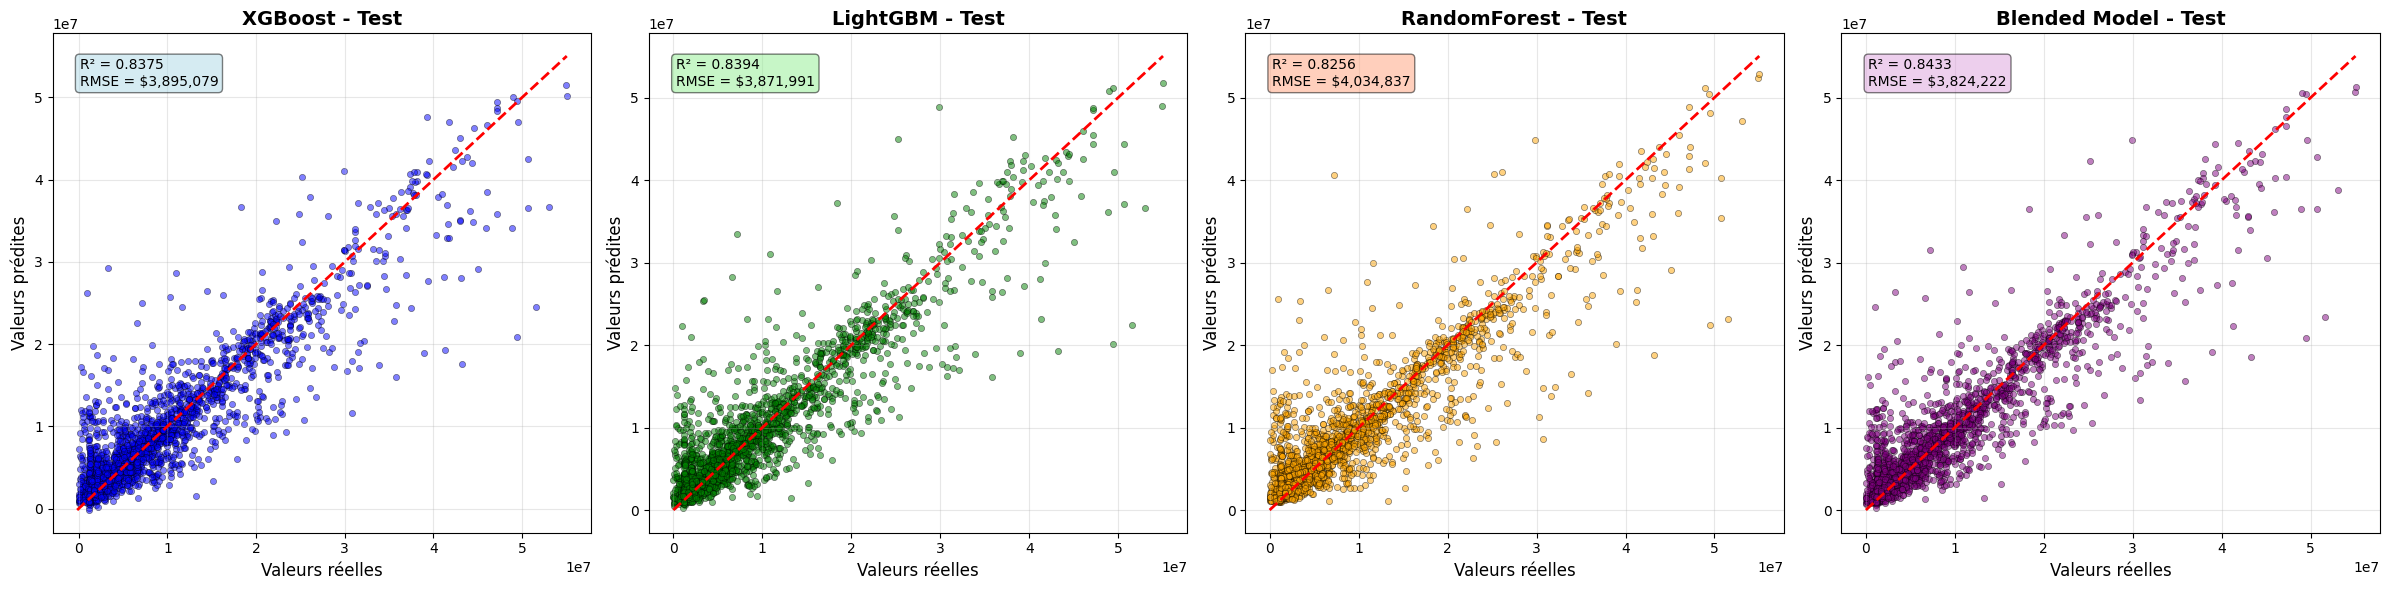

(<Figure size 2400x600 with 4 Axes>,
 array([<Axes: title={'center': 'XGBoost - Test'}, xlabel='Valeurs réelles', ylabel='Valeurs prédites'>,
        <Axes: title={'center': 'LightGBM - Test'}, xlabel='Valeurs réelles', ylabel='Valeurs prédites'>,
        <Axes: title={'center': 'RandomForest - Test'}, xlabel='Valeurs réelles', ylabel='Valeurs prédites'>,
        <Axes: title={'center': 'Blended Model - Test'}, xlabel='Valeurs réelles', ylabel='Valeurs prédites'>],
       dtype=object))

In [7]:
from train_blended_model import optimize_blend_and_params, plot_predictions, get_feature_importance, train_blended_model

# Décommenter la recherche des meilleurs poids pour le modèle blendé (XGBoost + LightGBM + Random Forest)

# Ici on trouve XGBoost=0.4, LightGBM=0.4, RandomForest=0.2 + params par défault dans train_blended_model

# Tourne entre 5min et 10min

# best_blend_and_params = optimize_blend_and_params(df_preprocessed, target_column='next_adjusted_salary')

model = train_blended_model(df_preprocessed)

get_feature_importance(model)

plot_predictions(model)

Comme prévu, on a un modèle extrêment performant grâce à la présence du salaire de l'année précédente dans les donnée. Dans le modèle RandomForestRegresssor il est quasiment 40x plus important que le second paramètre le plus important. 10x pour le XGBoost et 2x pour le LightGBM. (essayer d'expliquer pourquoi)

Essayons maintenant la même chose en enlevant le salaire de l'année précédente de la base de donnée.

Taille du jeu d'entraînement: 5354
Taille du jeu de test: 2295

Poids du blend: XGBoost=0.40, LightGBM=0.40, RandomForest=0.20

Entraînement du modèle XGBoost...
Entraînement du modèle LightGBM...
Entraînement du modèle RandomForest...

Blending des prédictions...

RÉSULTATS DES MODÈLES INDIVIDUELS

XGBoost:
   Train R²: 0.9128  |  Test R²: 0.7235
   Train RMSE: $2,829,306.51  |  Test RMSE: $5,080,580.19

LightGBM:
   Train R²: 0.8831  |  Test R²: 0.7231
   Train RMSE: $3,276,112.38  |  Test RMSE: $5,083,699.71

RandomForest:
   Train R²: 0.8858  |  Test R²: 0.7001
   Train RMSE: $3,237,728.77  |  Test RMSE: $5,291,296.07

RÉSULTATS DU MODÈLE BLENDÉ

Performance sur l'ensemble d'ENTRAÎNEMENT:
   R² Score:  0.9015
   RMSE:      $3,007,078.21
   MAE:       $2,184,760.73

Performance sur l'ensemble de TEST:
   R² Score:  0.7287
   RMSE:      $5,032,660.87
   MAE:       $3,424,710.67

Top 5 features - XGBoost:
 feature  importance
     FTM    0.289215
     YOE    0.133819
    DREB    0.065

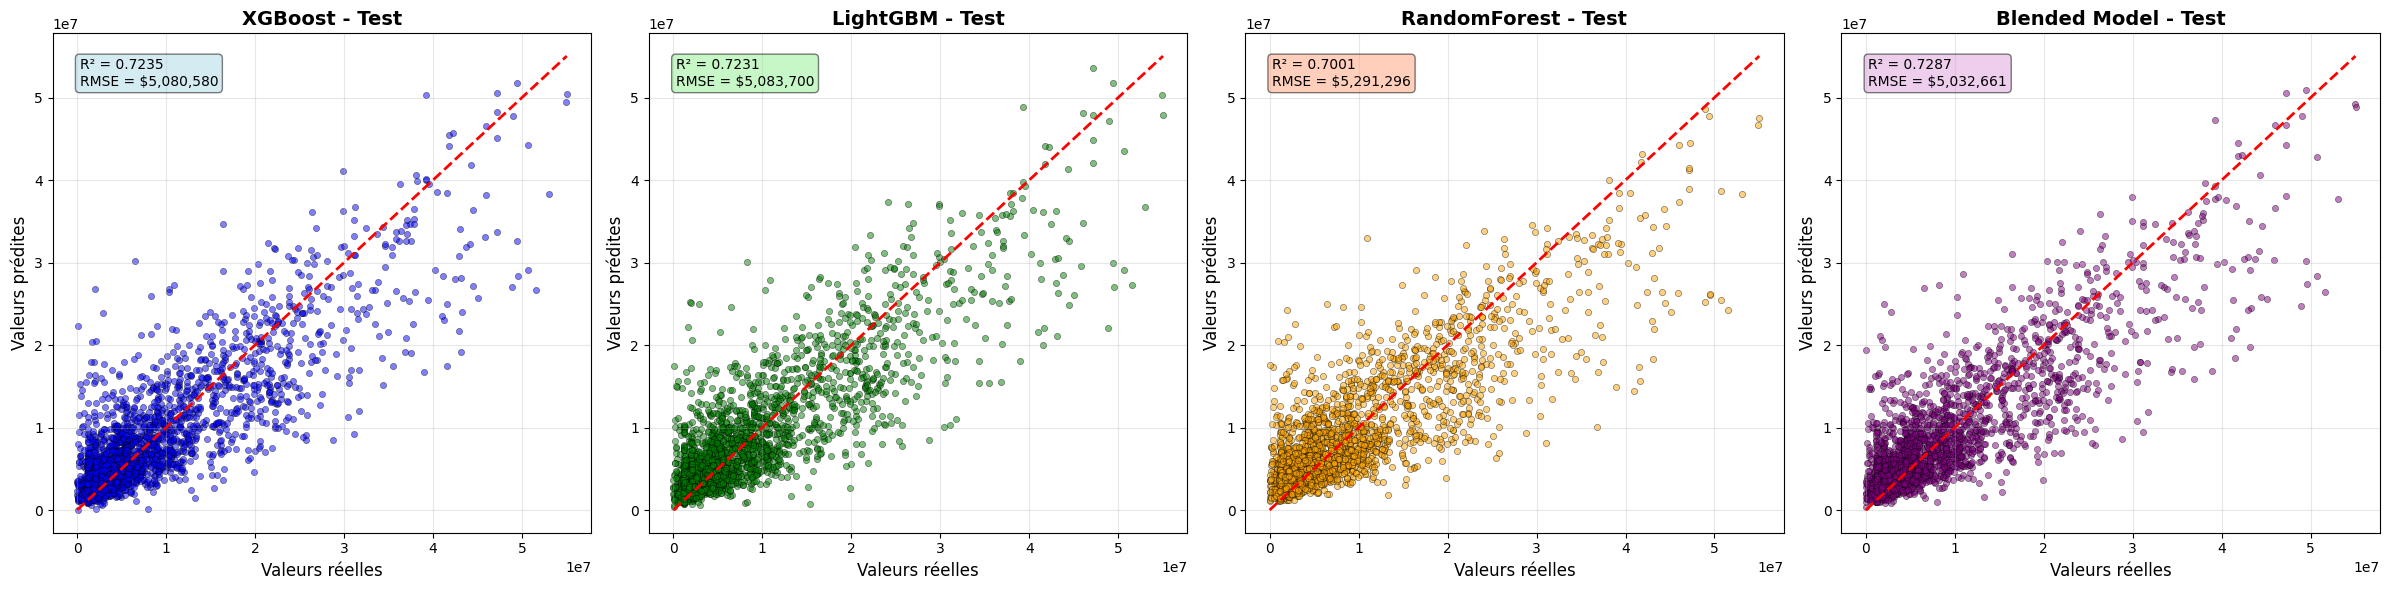

(<Figure size 2400x600 with 4 Axes>,
 array([<Axes: title={'center': 'XGBoost - Test'}, xlabel='Valeurs réelles', ylabel='Valeurs prédites'>,
        <Axes: title={'center': 'LightGBM - Test'}, xlabel='Valeurs réelles', ylabel='Valeurs prédites'>,
        <Axes: title={'center': 'RandomForest - Test'}, xlabel='Valeurs réelles', ylabel='Valeurs prédites'>,
        <Axes: title={'center': 'Blended Model - Test'}, xlabel='Valeurs réelles', ylabel='Valeurs prédites'>],
       dtype=object))

In [10]:
columns_to_remove= [
        'PLAYER_ID', 'PLAYER_NAME', 'NICKNAME', 'TEAM_ID', 
        'Team', 'Season', 'Year', 'Salary', 'Rank', 'adjusted_salary'
    ]

new_df_preprocessed, new_artifacts = preprocess_pipeline(df_clean, columns_to_remove=columns_to_remove, verbose=False)

new_model = train_blended_model(new_df_preprocessed)

get_feature_importance(new_model)

plot_predictions(new_model)